In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [50]:
plt.rcParams['figure.dpi'] = 300

In [5]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y    

In [7]:
def sampler(prob, n):
    samples = torch.empty(0)
    for idx, p in enumerate(prob):
        occurrences = torch.round(n * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

In [8]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [32]:
M = 8
n = 10_000
SNR_dB = 12
SNR = 10**(SNR_dB/10)
sigma2 = 1/SNR
nepochs = 4000

dec = Receiver(M)
loss_fn = nn.CrossEntropyLoss()

alphabet = np.arange(-(M-1),M,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
alphabet_t = torch.tensor(alphabet).float()

In [33]:
logits = torch.tensor([1.0]*M)
logits = nn.Parameter(torch.tensor([1.0]*M))

In [34]:
lr = 0.1
opt = optim.Adam( dec.parameters(), lr=lr)
opt.add_param_group({'params': logits})

In [35]:
def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those which where really sent
    return cf

for j in range(nepochs):
    probs =  nn.functional.softmax(logits, -1)  
    probs.retain_grad()
    
    # Sample indexes
    indices = sampler(probs, n)
    indices = indices.type(torch.LongTensor)

    # Modulation
    norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
    alphabet_norm =  alphabet_t * norm_factor 
    onehot = nn.functional.one_hot(indices, M).float()
    symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1)) 
    
    # Channel
    y = AWGN_channel(symbols, sigma2) 

    # Demodulator
    ll = dec(y.reshape(-1,1).float())
    app = nn.functional.softmax(ll, 1) #Q(X|Y)

    # Loss
    loss = loss_fn(ll, indices) - torch.sum(-probs*torch.log(probs))
    opt.zero_grad()
    loss.backward()
    
    # correction factor
    cf = - gradient_correction_factor(app, indices, probs, M) + torch.log(probs)
    
    probs.grad += cf.detach()
    
    opt.step()

    # Printout and visualization
    if j % 500 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

KeyboardInterrupt: 

In [13]:
probs

tensor([0.0265, 0.0783, 0.1622, 0.2330, 0.2330, 0.1622, 0.0783, 0.0265],
       grad_fn=<SoftmaxBackward0>)

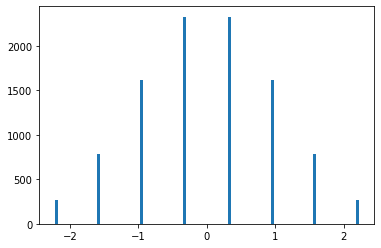

In [14]:
plt.hist(symbols.detach().numpy(), bins=100)
plt.show()

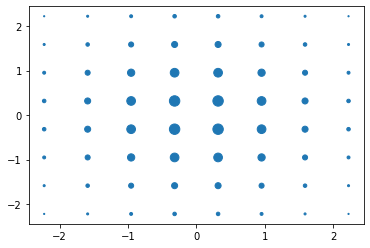

In [15]:
# Scatterplot
pp = (probs.reshape(-1,1)*probs.reshape(1,-1)).reshape(-1,1).detach().numpy()
alph = alphabet_norm.detach().numpy()
a = []
for c in np.flip(alph):
    for d in alph:
        a.append(d+1j*c)
plt.scatter(np.real(a), np.imag(a), pp*2000)   
plt.show()

### Compare Results

In [18]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [19]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [20]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [21]:
n = 100_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_64 = []
for snrdB in SNR_dBs:
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2 
    y = AWGN_channel_np(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))

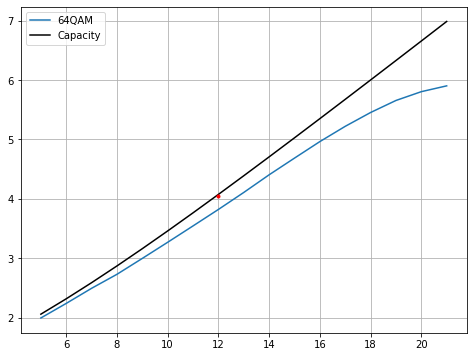

In [22]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]
plt.plot(SNR_dBs, mi_64, label = '64QAM')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='Capacity')
plt.plot(SNR_dB, -2*loss.detach()/np.log(2), color='red', marker='o', markersize=3)
plt.legend()
plt.grid()

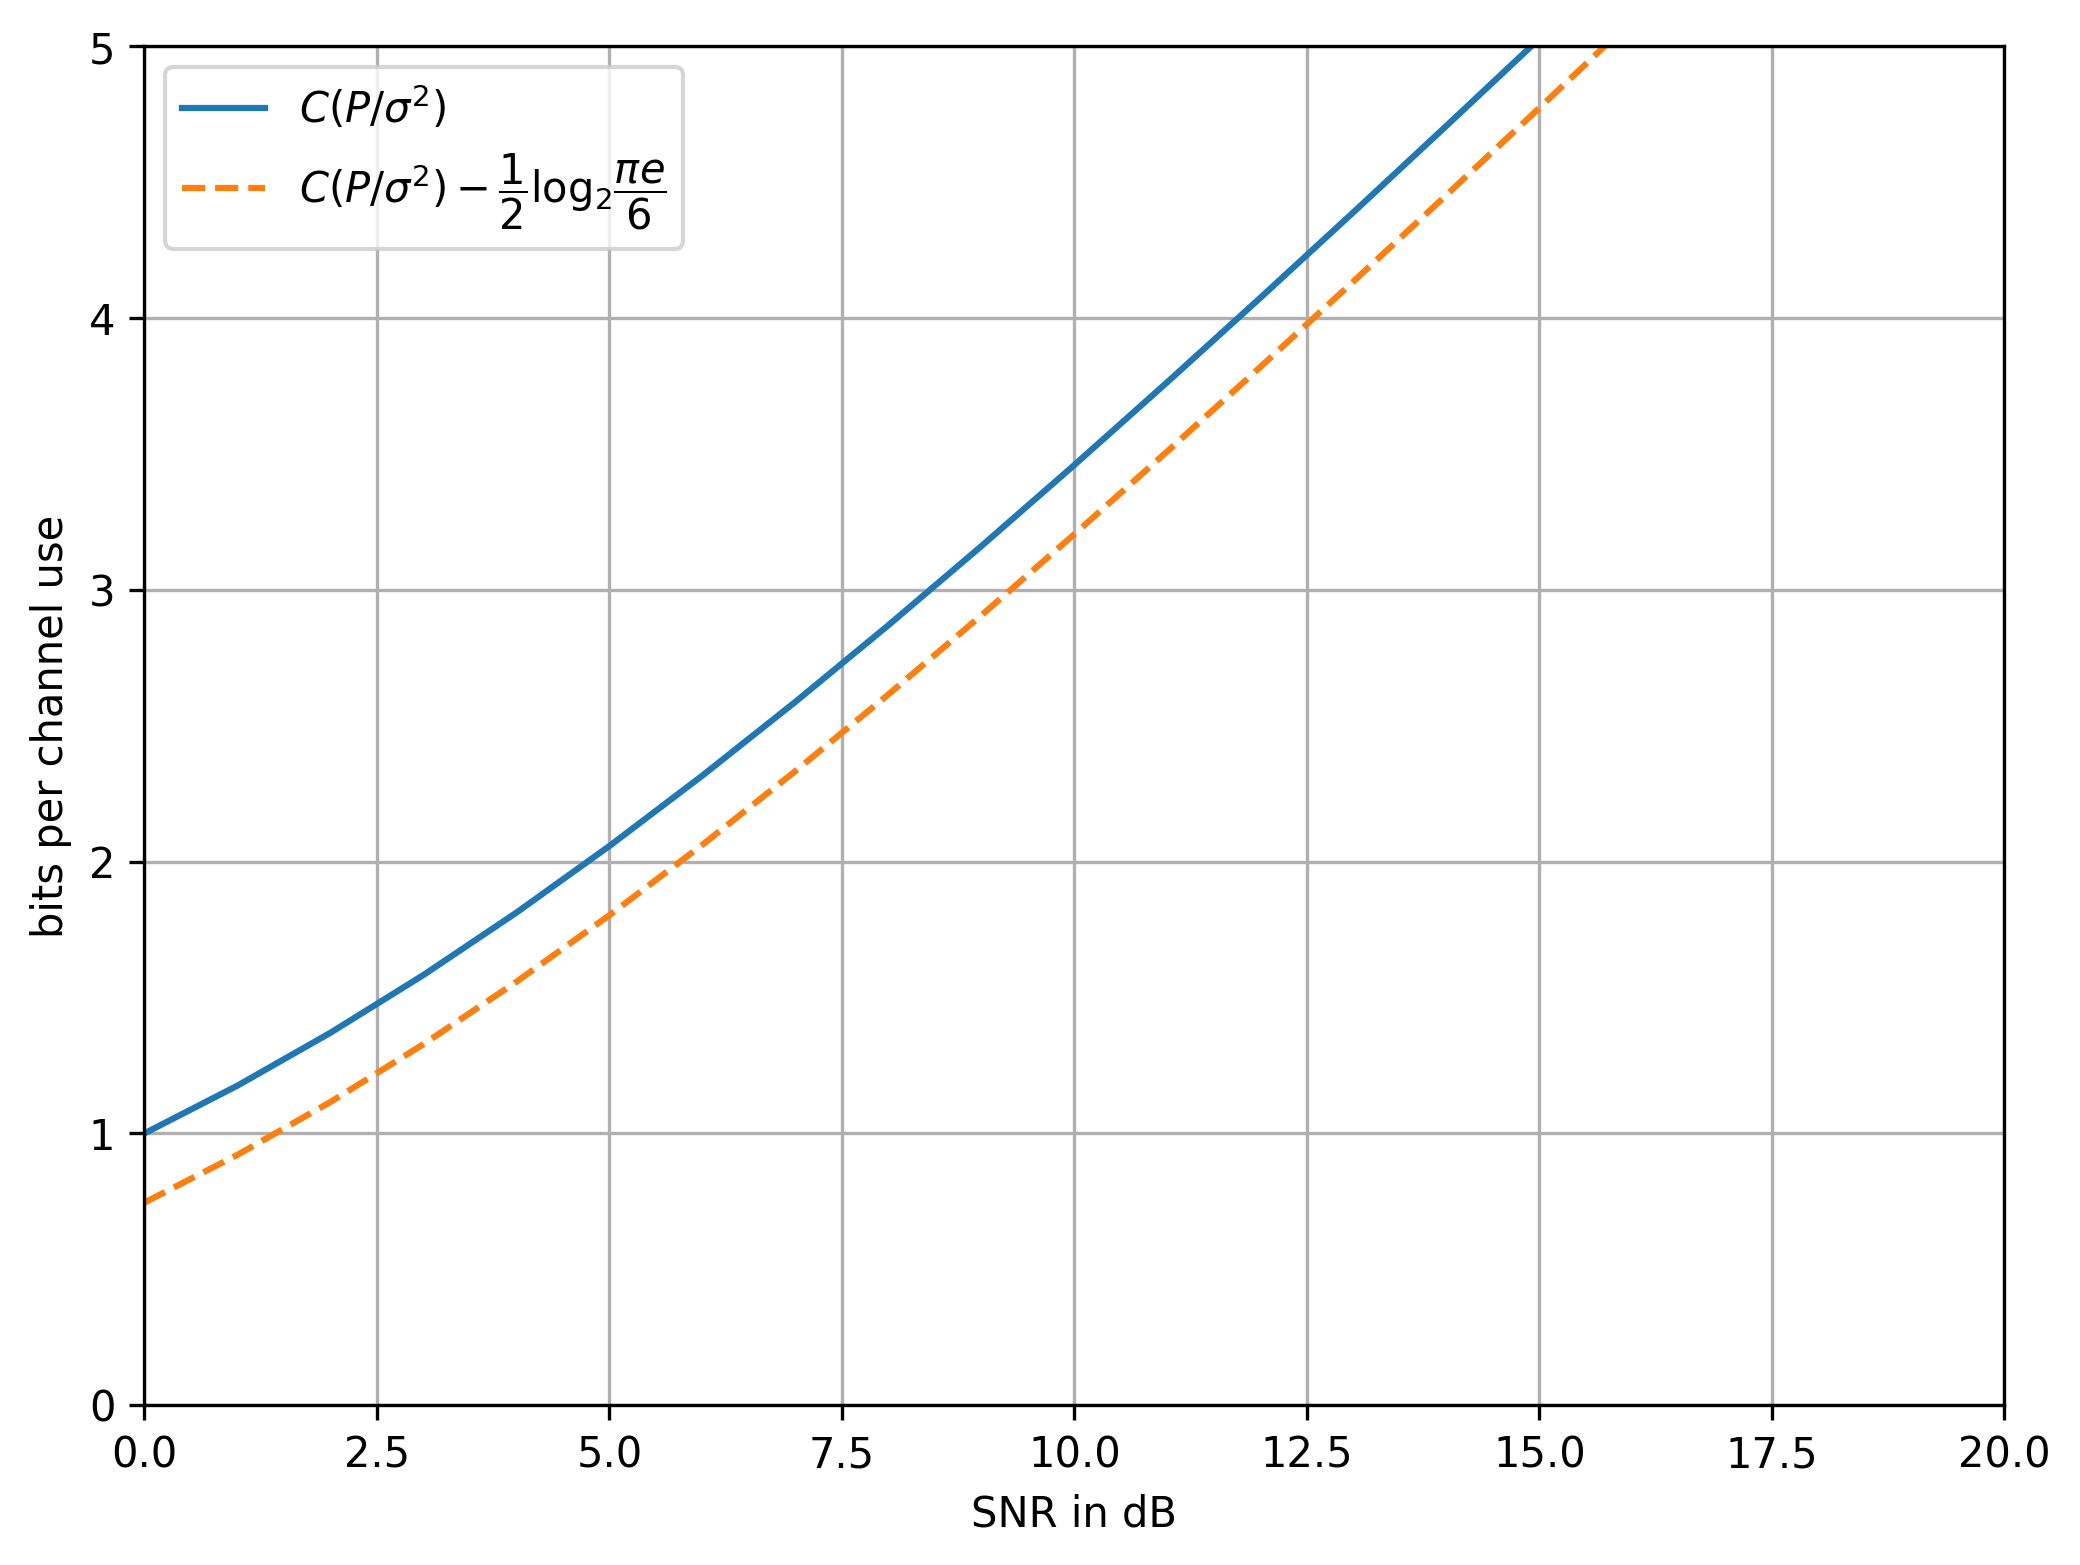

In [52]:
SNR_dBs = np.arange(0,20)
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='C0', label='$C(P/\sigma^2)$')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)) - 0.5*np.log2((np.pi*np.e)/6) , linestyle='dashed', color='C1', label='$C(P/\sigma^2) - \dfrac{1}{2}\log_2\dfrac{\pi e}{6}$')
plt.grid()
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
plt.xlim([0, 20])
plt.ylim([0, 5])
# plt.title('AWGN channel capacity gap')
plt.legend()